In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!git clone https://github.com/dorabangs/ant_bee.git

# **Pretrained alexnet model 사용**

### **fixed feature extractor**
### fine-tune 마지막 fully connected layer

#### **<모듈 임포트>**

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import os
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### **<GPU 확인, 사용할 device 설정>**

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### **<Seed/Random state 고정, 재현성을 위해>**

In [72]:
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

#### **<데이터 불러오기>**
#### 개미와 벌 분류하기
#### train data class당 대략 120개
#### validatation data class당 대략 70~80개

In [73]:
data_transforms = {
    'train':transforms.Compose([ # Composes several transforms together.
        transforms.RandomResizedCrop(224), # size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # Sequence of means for each channel, Sequence of standard deviations for each channel.
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [74]:
data_dir = "/content/ant_bee/ant_bee"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

#### **<데이터 시각화>**

In [75]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # channel, height, width -> height, width, channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Given an interval, values outside the interval are clipped to the interval edges.
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

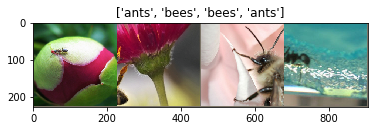

In [76]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) # batch, ch, h,w
# Make a grid from batch
out = torchvision.utils.make_grid(inputs) # ch,h,width*batch
imshow(out, title=[class_names[x] for x in classes])

### **<pretrained 모델 불러오기>**

In [77]:
alexnet = models.alexnet(pretrained=True)
#vgg16 = models.vgg16(pretrained=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

### **<fine-tuning : 마지막 Linear layer>**

In [78]:
for param in alexnet.parameters():
    param.requires_grad = False

In [79]:
#Parameters of newly constructed modules have requires_grad=True by default
num_in = alexnet.classifier[-1].in_features
alexnet.classifier[-1] = nn.Linear(num_in,2)

In [80]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [81]:
alexnet = alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.classifier[-1].parameters(), 
                      lr=0.001, 
                      momentum=0.9)
cus_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=7,
                                       gamma=0.1)

In [84]:
num_epochs = 25

In [85]:
best_model_wts = copy.deepcopy(alexnet.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            cus_lr_scheduler.step()
            alexnet.train()  # Set model to training mode
        else:
            alexnet.eval()   # Set model to evaluate mode
    
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = alexnet(inputs)
                _, preds = torch.max(outputs, 1) #outputs값 중에서 큰 class값을 가져옴
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward() # backpropagation
                    optimizer.step() # model weight update
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase] #float은 7자리, double은 15~16자리까지 표현가능
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(alexnet.state_dict())

    print()

print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
alexnet.load_state_dict(best_model_wts)

Epoch 1/25
----------
train Loss: 0.1448 Acc: 0.9590
val Loss: 0.6617 Acc: 0.9281

Epoch 2/25
----------
train Loss: 0.1887 Acc: 0.9467
val Loss: 0.6616 Acc: 0.9281

Epoch 3/25
----------
train Loss: 0.1915 Acc: 0.9549
val Loss: 0.6616 Acc: 0.9281

Epoch 4/25
----------
train Loss: 0.2691 Acc: 0.9426
val Loss: 0.6615 Acc: 0.9281

Epoch 5/25
----------
train Loss: 0.3417 Acc: 0.9262
val Loss: 0.6615 Acc: 0.9281

Epoch 6/25
----------
train Loss: 0.2547 Acc: 0.9303
val Loss: 0.6615 Acc: 0.9281

Epoch 7/25
----------
train Loss: 0.3518 Acc: 0.9385
val Loss: 0.6614 Acc: 0.9281

Epoch 8/25
----------
train Loss: 0.2529 Acc: 0.9508
val Loss: 0.6614 Acc: 0.9281

Epoch 9/25
----------
train Loss: 0.2641 Acc: 0.9303
val Loss: 0.6614 Acc: 0.9281

Epoch 10/25
----------
train Loss: 0.2347 Acc: 0.9426
val Loss: 0.6614 Acc: 0.9281

Epoch 11/25
----------
train Loss: 0.1332 Acc: 0.9631
val Loss: 0.6614 Acc: 0.9281

Epoch 12/25
----------
train Loss: 0.1984 Acc: 0.9549
val Loss: 0.6614 Acc: 0.9281

E

IncompatibleKeys(missing_keys=[], unexpected_keys=[])